# Client code for SABR model calibration

This is a demo for the calibration of the SABR model by Hagan et al. In this stochastic volatility model the forward rate $F_t$ satisfies the dynamics
$$dF_t = \alpha F_t^{\beta} dW_t^{F},$$
and also
$$d\alpha_t = \nu \alpha_t dW_t^{\alpha},$$
and the forward rate $F_t$ is correlated with the volatility process $\alpha_t$ as 
$$dW_t^{F} dW_t^{\alpha}=\rho dt.$$

The model is often used for swaption implied volatility interpolation purposes. The calibration is based on the approximation for the implied volatility of a European call or put.

In [1]:
import pandas as pd
import xlrd
import matplotlib.pyplot as plt

from sabr_calibrator import *

In [2]:
# ----- load the data and set the starting parameters
market_data = xlrd.open_workbook('swaption_mkt_volas.xlsx').sheet_by_name('swaption_volas')
starting_values = np.array([0.0011, 0.5, 0, 0.0011])  # starting values for: alpha, beta, rho, nu

Calibrate the parameters and plot the swaption implied volas:

In [4]:
# ----- calibrate the parameters, get the swaption implied volas
#       (there is a separate set of parameters calibrated for each smile:
#        a set of {alpha, beta, rho, nu} for each combination of expiry and tenor)
sabr_calibr = SABRCalibrator(starting_values, market_data)
strike_spreads, expiries, tenors = sabr_calibr.data_loader.strike_spreads, sabr_calibr.data_loader.expiries, \
                                   sabr_calibr.data_loader.tenors

In [5]:
# ----- get the implied vola matrix
sabr_vol_matrix = sabr_calibr.sabr_vol_matrix
sabr_vol_df = pd.DataFrame(sabr_vol_matrix, columns=strike_spreads)\
    .assign(maturity=expiries)\
    .assign(tenor=tenors)\
    .loc[:, ["maturity", "tenor"] + strike_spreads]
sabr_vol_df["maturity"] = sabr_vol_df["maturity"].apply(get_months_years)
sabr_vol_df["tenor"] = sabr_vol_df["tenor"].apply(get_months_years)
sabr_vol_df["maturity_tenor"] = sabr_vol_df["maturity"] + sabr_vol_df["tenor"]

Text(0.5, 1.0, 'SABR swaption implied vola smiles')

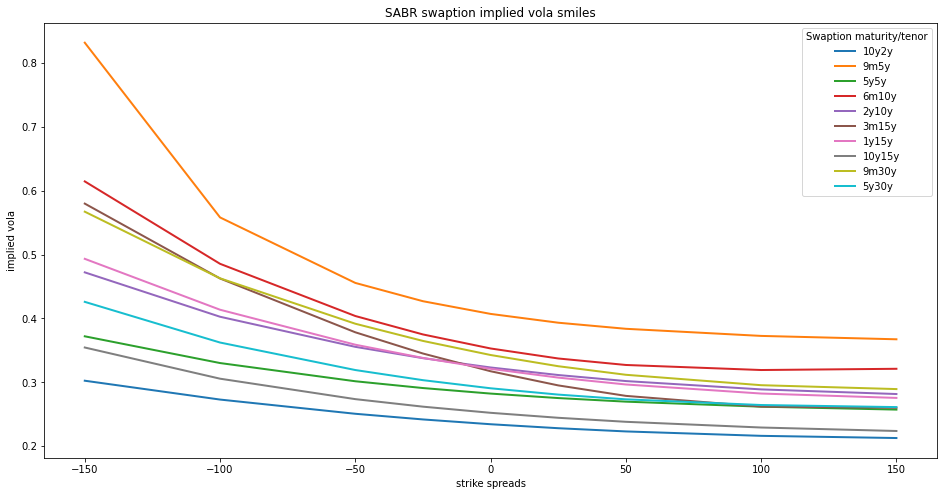

In [6]:
# ----- plot swaption implied volas
sabr_vol_df_abstract = sabr_vol_df.iloc[::3, :].iloc[2:]
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.plot(sabr_vol_df_abstract.loc[:, strike_spreads].T, linewidth=2)
ax.legend(sabr_vol_df_abstract["maturity_tenor"].values, title="Swaption maturity/tenor")
ax.set_xlabel("strike spreads")
ax.set_ylabel("implied vola")
ax.set_title("SABR swaption implied vola smiles")